In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rc
import math
from mpl_toolkits.axes_grid1 import ImageGrid
import diverge.output as do

In [2]:
def save_SCgap(data, mod, channel, plot_vector, gap_file="gap_file.txt"):
    kmesh= mod.kmesh
    nkp = kmesh.shape[0]
    ofrom = data.mi_to_ofrom
    oto = data.mi_to_oto
    miR = data.mi_to_R
    #print(miR)
    mirr = miR
    uniquemiR = np.unique(miR, axis=0)
    #print(np.sort(uniquemiR))
    # reexpress R vectors is absolute units
    miR = miR[:,0][:,None]*mod.lattice[0,:][None,:] + miR[:,1][:,None]*mod.lattice[1,:][None,:] + miR[:,2][:,None]*mod.lattice[2,:][None,:]
    #print(miR)
    uniquemiR_lat = uniquemiR[:,0][:,None]*mod.lattice[0,:][None,:] + uniquemiR[:,1][:,None]*mod.lattice[1,:][None,:] + uniquemiR[:,2][:,None]*mod.lattice[2,:][None,:]
    ff_ = np.exp(1j*np.einsum("ri,ki->kr",miR,kmesh))
    #print(ff_.shape)
    nsites = data.n_orb
    nbonds = data.n_bonds
    norbff = data.n_orbff
    nspin = data.n_spin
    no = nsites
    ns = nspin
    
    #print("plotvectorshape", plot_vector[:,:,7:16].shape)
    plot_vector = np.copy(plot_vector)
    #plot_vector[:,:,7:16] *= 0
    #plot_vector[:,:,18:] *= 0
    Ukoo = np.zeros((nsites, nspin ,nsites, nspin, nkp), dtype=complex)
    # go to momentum - orbital space
    for idx in range(len(ofrom)):
        o1 = int(ofrom[idx])
        o2 = int(oto[idx])
        val = plot_vector[:,:,idx][:,:,None]*ff_[:,idx][None,None,:]
        Ukoo[o1,:,o2,:,:] += val
    Ukoo = Ukoo.reshape(no*ns,no*ns,nkp)

    
    if channel == "C":
        Ukoo = Ukoo + np.conj(Ukoo.swapaxes(0,1))

    # This gives the evec in ff and orbital space.
    Ukooo = np.zeros((nsites,nsites, len(uniquemiR)), dtype=complex)
    # go to momentum - orbital space
    for idx in range(len(ofrom)):
        o1 = int(ofrom[idx])
        o2 = int(oto[idx])
        aa=0
        for j in range(len(uniquemiR)):
            #print("TEST", np.allclose(mirr[idx], uniquemiR[j]))
            if np.allclose(mirr[idx], uniquemiR[j]):
                aa=j
        val = plot_vector[:,:,idx][:,:,None]
        Ukooo[o1,o2,aa] += val

    normo = plt.Normalize(-np.max(np.abs(Ukooo)),np.max(np.abs(Ukooo)))
    normo = np.ndarray.flatten(Ukooo)[np.argmax(np.abs(np.ndarray.flatten(Ukooo)))]
    Ukooo *= np.conj(normo)/np.abs(normo)

    #print(uniquemiR)
    #print(Ukooo.shape)
    #exit(0)
    #for i in range(int(len(uniquemiR))):
    #    print(np.abs(  Ukooo[:,:,i]))
    #    print(np.angle(Ukooo[:,:, i]))
    #    print("ff",     uniquemiR[i])
    #    print("ff_lat",     uniquemiR_lat[i])

    f = open(gap_file, "w")
    for i in range(int(len(uniquemiR))):
        Rx = uniquemiR[i][0]
        Ry = uniquemiR[i][1]
        Rz = uniquemiR[i][2]
        for o1 in range(len(Ukooo)):
            for o2 in range(len(Ukoo[o1])):
                line =f"{Rx} {Ry} {Rz} {o1} {o2} {np.real(Ukooo[o1,o2,i])} {np.imag(Ukooo[o1,o2,i])}\n"
                f.write(line)
    f.close()

In [3]:
def plot_SCgap(data, mod, channel, plot_vector, eval, U, mu, model,  real_space=False):
    kmesh= mod.kmesh
    nkp = kmesh.shape[0]
    ofrom = data.mi_to_ofrom
    oto = data.mi_to_oto
    miR = data.mi_to_R
    #print(miR)
    mirr = miR
    uniquemiR = np.unique(miR, axis=0)
    #print(np.sort(uniquemiR))
    # reexpress R vectors is absolute units
    miR = miR[:,0][:,None]*mod.lattice[0,:][None,:] + miR[:,1][:,None]*mod.lattice[1,:][None,:] + miR[:,2][:,None]*mod.lattice[2,:][None,:]
    #print(miR)
    uniquemiR_lat = uniquemiR[:,0][:,None]*mod.lattice[0,:][None,:] + uniquemiR[:,1][:,None]*mod.lattice[1,:][None,:] + uniquemiR[:,2][:,None]*mod.lattice[2,:][None,:]
    ff_ = np.exp(1j*np.einsum("ri,ki->kr",miR,kmesh))
    #print(ff_.shape)
    nsites = data.n_orb
    nbonds = data.n_bonds
    norbff = data.n_orbff
    nspin = data.n_spin
    no = nsites
    ns = nspin
    
    plot_vector = np.copy(plot_vector)
   
    Ukoo = np.zeros((nsites, nspin ,nsites, nspin, nkp), dtype=complex)
   
    for idx in range(len(ofrom)):
        o1 = int(ofrom[idx])
        o2 = int(oto[idx])
        val = plot_vector[:,:,idx][:,:,None]*ff_[:,idx][None,None,:]
        Ukoo[o1,:,o2,:,:] += val
    Ukoo = Ukoo.reshape(no*ns,no*ns,nkp)

    
    if channel == "C":
        Ukoo = Ukoo + np.conj(Ukoo.swapaxes(0,1))

    
    Ukooo = np.zeros((nsites,nsites, len(uniquemiR)), dtype=complex)

    for idx in range(len(ofrom)):
        o1 = int(ofrom[idx])
        o2 = int(oto[idx])
        aa=0
        for j in range(len(uniquemiR)):
    
            if np.allclose(mirr[idx], uniquemiR[j]):
                aa=j
        val = plot_vector[:,:,idx][:,:,None]
        Ukooo[o1,o2,aa] += val

    normo = plt.Normalize(-np.max(np.abs(Ukooo)),np.max(np.abs(Ukooo)))
    normo = np.ndarray.flatten(Ukooo)[np.argmax(np.abs(np.ndarray.flatten(Ukooo)))]
    Ukooo *= np.conj(normo)/np.abs(normo)

    sub_lat = mod.positions

    if real_space == True:
        full(uniquemiR_lat, sub_lat, np.swapaxes(Ukooo,0,2), save_path="test")

    norm = np.ndarray.flatten(Ukoo)[np.argmax(np.abs(np.ndarray.flatten(Ukoo)))]
    Ukoo *= np.conj(norm)/np.abs(norm)
    norm = plt.Normalize(-np.max(np.abs(Ukoo)),np.max(np.abs(Ukoo)))
    fig = plt.figure(figsize=(4.2,3.15))
    ax = ImageGrid(fig, 111,
                    nrows_ncols = (no*ns,no*ns),
                    axes_pad = 0.0,
                    share_all=True,
                    cbar_location = "right",
                    cbar_mode="single",
                    cbar_size="5%",
                    cbar_pad=0.0
                    )
    for o2 in range(no*ns):
        for o1 in range(no*ns):
            q = int(o1+no*ns*o2)
            ima = ax[q].scatter(kmesh[:,1],kmesh[:,0],c = np.abs(Ukoo[o1,o2,:]),norm = plt.Normalize(0,np.max(np.abs(Ukoo))), s = 10, linewidths=0.1,cmap="plasma")
            ax[q].set_xticks([])
            ax[q].set_yticks([])
            ax[q].set_aspect('equal')
    #plot title in top center of image grid
    center_idx = math.ceil(no*ns/2)-1
    ax[center_idx].set_title(channel + "  " + str(eval))
    bara = fig.colorbar(ima,cax=ax.cbar_axes[0])

    fig = plt.figure(figsize=(4.2,3.15))
    ax = ImageGrid(fig, 111,
                    nrows_ncols = (no*ns,no*ns),
                    axes_pad = 0.0,
                    share_all=True,
                    cbar_location = "right",
                    cbar_mode="single",
                    cbar_size="5%",
                    cbar_pad=0.0
                    )
    for o2 in range(no*ns):
        for o1 in range(no*ns):
            q = int(o1+no*ns*o2)
            ima = ax[q].scatter(kmesh[:,1],kmesh[:,0],c = np.angle(Ukoo[o1,o2,:]), vmin=-np.pi, vmax=np.pi, s = 10, linewidths=0.1,cmap="twilight") #norm = plt.Normalize(-1,1)
            ax[q].set_xticks([])
            ax[q].set_yticks([])
            ax[q].set_aspect('equal')
            
    ax[center_idx].set_title(channel + "  " + str(eval))
    bara = fig.colorbar(ima,cax=ax.cbar_axes[0])

    fig = plt.figure(figsize=(4.2,3.15))
    ax = ImageGrid(fig, 111,
                    nrows_ncols = (no*ns,no*ns),
                    axes_pad = 0.0,
                    share_all=True,
                    cbar_location = "right",
                    cbar_mode="single",
                    cbar_size="5%",
                    cbar_pad=0.0
                    )
    # normalize and gauge maximal value to be real
    norm = plt.Normalize(-np.max(np.abs(Ukoo)),np.max(np.abs(Ukoo)))
    norm = np.ndarray.flatten(Ukoo)[np.argmax(np.abs(np.ndarray.flatten(Ukoo)))]
    Ukoo *= np.conj(norm)/np.abs(norm)
    norm = plt.Normalize(-np.max(np.abs(Ukoo)),np.max(np.abs(Ukoo)))
    for o2 in range(no*ns):
        for o1 in range(no*ns):
            q = int(o1+no*ns*o2)
            ima = ax[q].scatter(kmesh[:,1],kmesh[:,0],c = np.real(Ukoo[o1,o2,:]),norm = norm, s = 10, linewidths=0.1,cmap="bwr")
            #ima = ax[q].scatter(kmesh[:,1],kmesh[:,0],c = np.angle(Ukoo[o1,o2,:]), s = 10*np.abs(Ukoo[o1,o2,:]), linewidths=0.1,cmap="twilight")
            ax[q].set_xticks([])
            ax[q].set_yticks([])
            ax[q].set_aspect('equal')

    for i in range(no * ns):
        ax[i].set_xlabel(r'$k_x$')
        ax[i].set_ylabel(r'$k_y$')
        ax[i].set_title(f'SC order parameter at U ={U} $\mu$ = {mu}')
            #ax[q].set_title(q)
    bara = fig.colorbar(ima,cax=ax.cbar_axes[0])
    bara.set_label('Magnitude')
    plt.savefig(f"Sc_gap_{U}_{mu}.png")
    plt.show()

/tmp/ipykernel_3430/3296732240.py:51: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  Ukooo[o1,o2,aa] += val


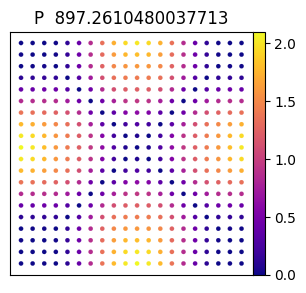

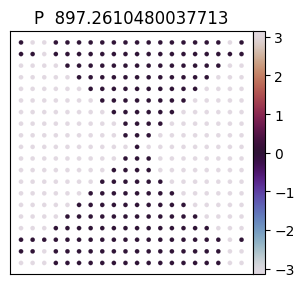

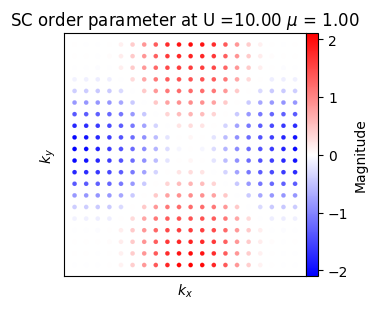

In [4]:
nk =20
nkf = 5
Us = "10.00"
model = "1NN"
mus = "1.00"
    


ff = "4.00"
    #La3Ni2O7_p100_8_4_4.00_2.00_1.00_out
mod = do.read(f"1NN_{nk}_{nkf}_{Us}_{mus}_mod.dvg")
mod.klabels=["G","M","X","G"]

out = do.read(f"1NN_{nk}_{nkf}_{Us}_{mus}_out.dvg")

plot_SCgap(out,mod,"P",out.Pvec[0],out.Pval[0], Us, mus, model,  real_space=False,)

/tmp/ipykernel_3430/3296732240.py:51: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  Ukooo[o1,o2,aa] += val


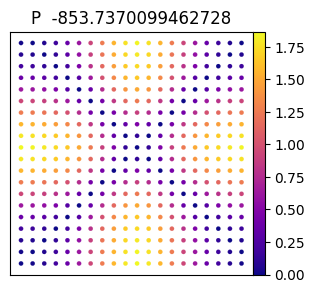

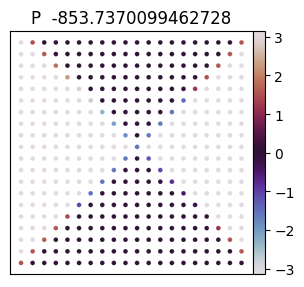

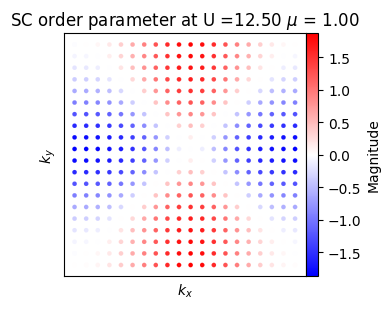

In [5]:
nk =20
nkf = 5
Us = "12.50"
model = "1NNN t' = 0.25"
mus = "1.00"
    


ff = "4.00"
    #La3Ni2O7_p100_8_4_4.00_2.00_1.00_out
mod = do.read(f"1NN_{nk}_{nkf}_{Us}_{mus}_mod.dvg")
mod.klabels=["G","M","X","G"]

out = do.read(f"1NN_{nk}_{nkf}_{Us}_{mus}_out.dvg")

plot_SCgap(out,mod,"P",out.Pvec[0],out.Pval[0], Us, mus, model,  real_space=False,)

/tmp/ipykernel_3430/3296732240.py:51: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  Ukooo[o1,o2,aa] += val


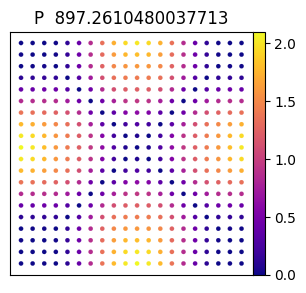

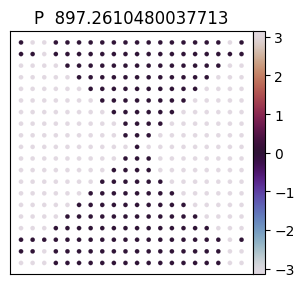

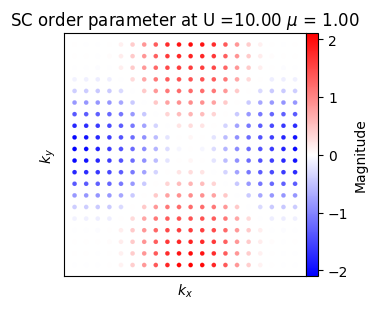

In [6]:
nk =20
nkf = 5
Us = "10.00"
model = "1NNN ,t' =0.25"
mus = "1.00"
    


ff = "4.00"
    #La3Ni2O7_p100_8_4_4.00_2.00_1.00_out
mod = do.read(f"1NN_{nk}_{nkf}_{Us}_{mus}_mod.dvg")
mod.klabels=["G","M","X","G"]

out = do.read(f"1NN_{nk}_{nkf}_{Us}_{mus}_out.dvg")

plot_SCgap(out,mod,"P",out.Pvec[0],out.Pval[0], Us, mus, model,  real_space=False,)

/tmp/ipykernel_3430/3296732240.py:51: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  Ukooo[o1,o2,aa] += val


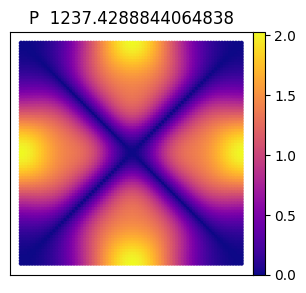

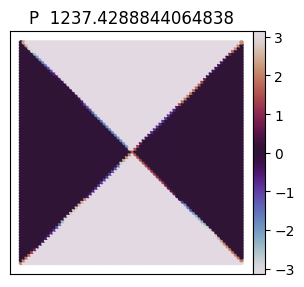

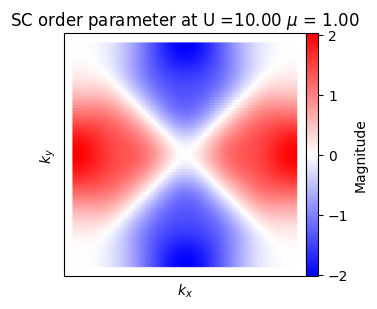

In [7]:
nk =80
nkf = 5
Us = "10.00"
model = "1NN ,t =0.25"
mus = "1.00"
    


ff = "4.00"
    #La3Ni2O7_p100_8_4_4.00_2.00_1.00_out
mod = do.read(f"1NN_{nk}_{nkf}_{Us}_{mus}_mod.dvg")
mod.klabels=["G","M","X","G"]

out = do.read(f"1NN_{nk}_{nkf}_{Us}_{mus}_out.dvg")

plot_SCgap(out,mod,"P",out.Pvec[0],out.Pval[0], Us, mus, model,  real_space=False,)

/tmp/ipykernel_3430/3296732240.py:51: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  Ukooo[o1,o2,aa] += val


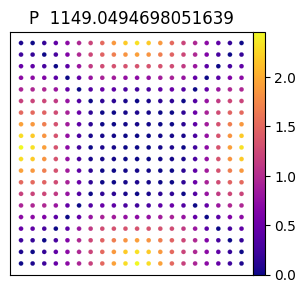

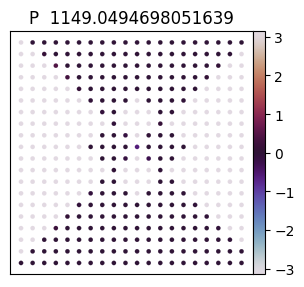

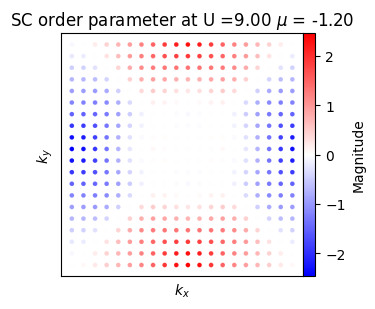

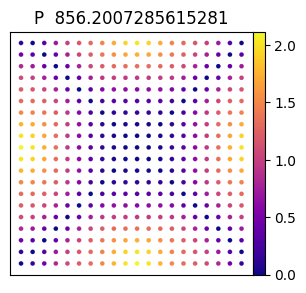

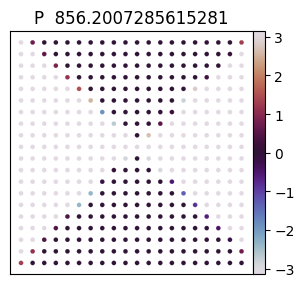

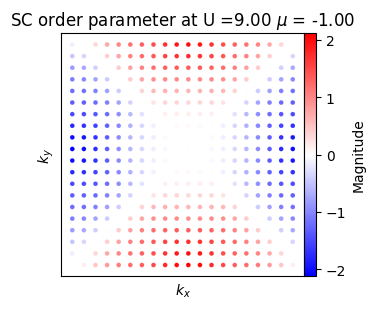

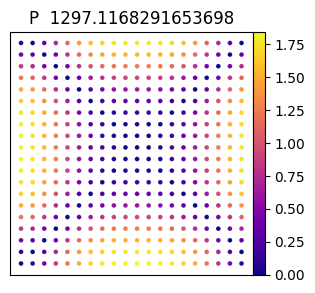

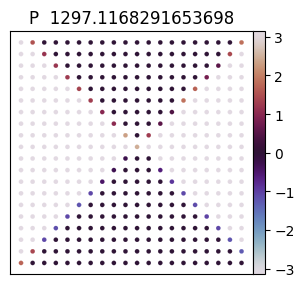

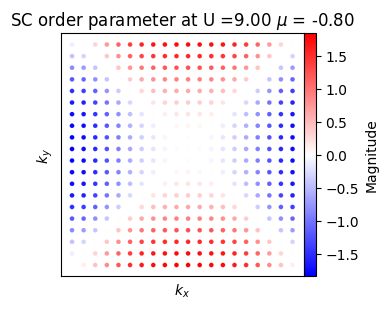

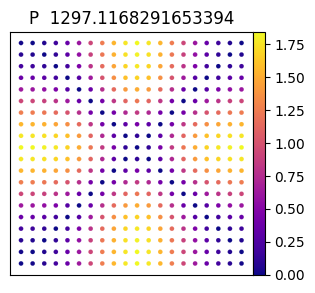

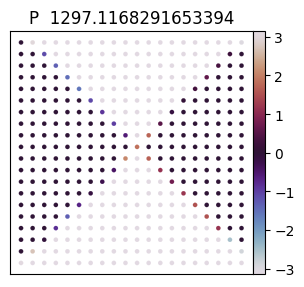

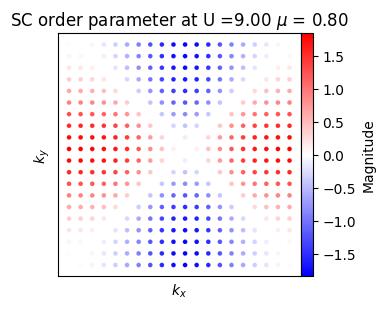

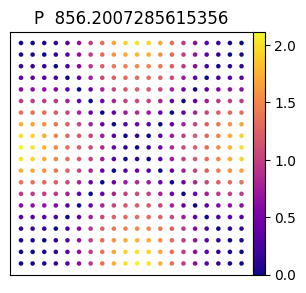

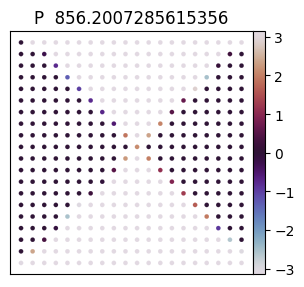

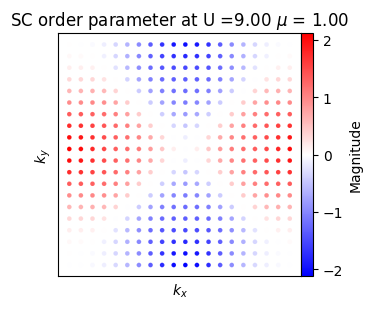

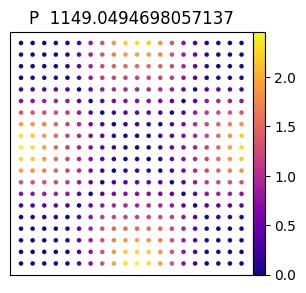

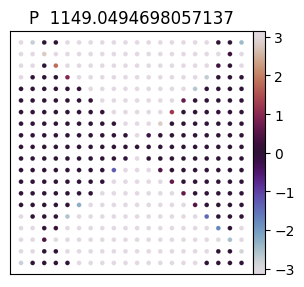

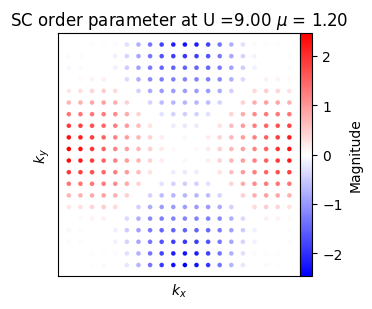

In [8]:
nk = 20 
nkf = 5
Us = "9.00"
model = "1NN t' = 0.00"
mu = [ "-1.20", "-1.00", "-0.80", "0.80", "1.00", "1.20" ]
    
for mus in mu: 

    ff = "4.00"
    #La3Ni2O7_p100_8_4_4.00_2.00_1.00_out
    mod = do.read(f"1NN_{nk}_{nkf}_{Us}_{mus}_mod.dvg")
    mod.klabels=["G","M","X","G"]

    out = do.read(f"1NN_{nk}_{nkf}_{Us}_{mus}_out.dvg")

    plot_SCgap(out,mod,"P",out.Pvec[0],out.Pval[0], Us, mus, model,  real_space=False,)

/tmp/ipykernel_3430/3296732240.py:51: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  Ukooo[o1,o2,aa] += val


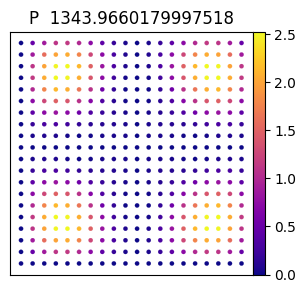

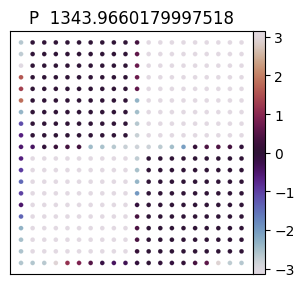

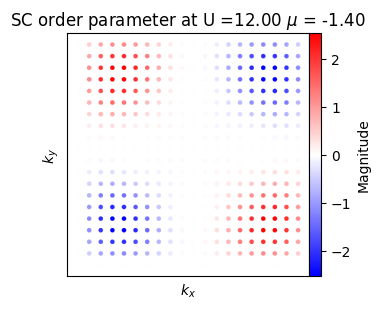

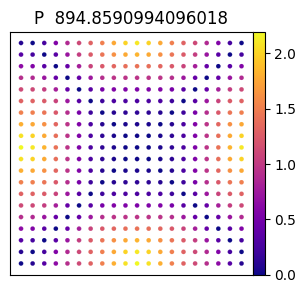

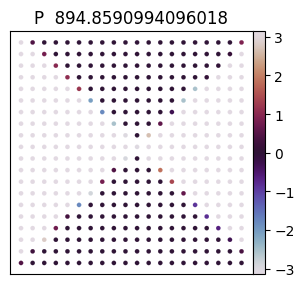

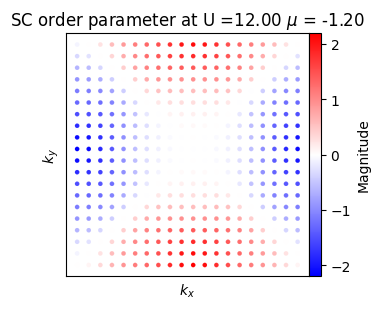

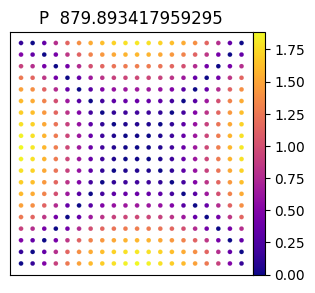

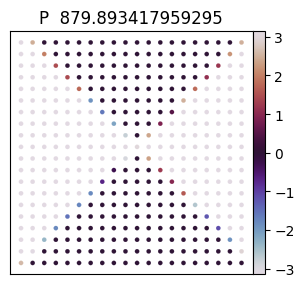

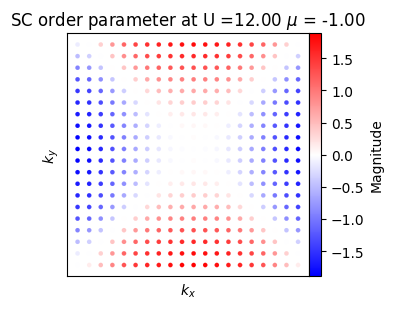

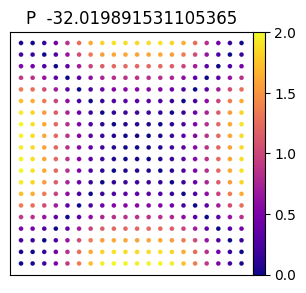

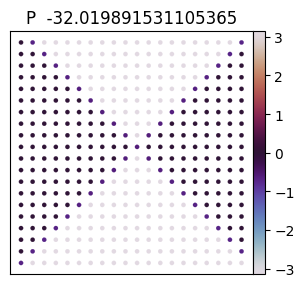

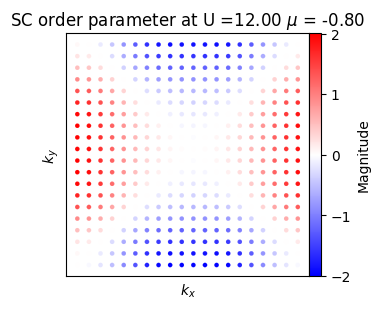

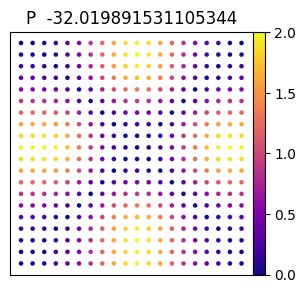

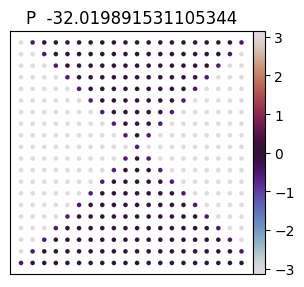

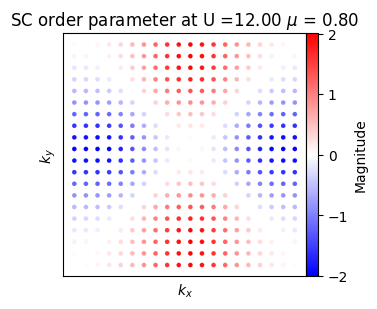

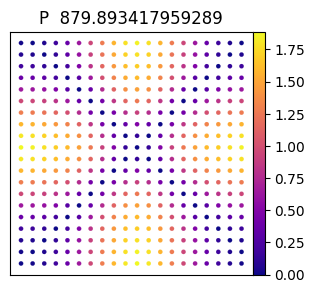

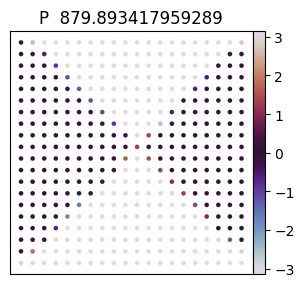

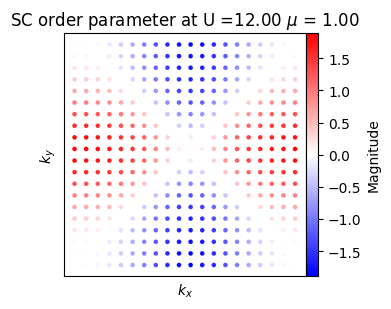

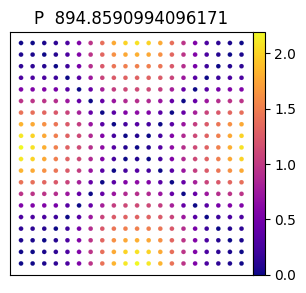

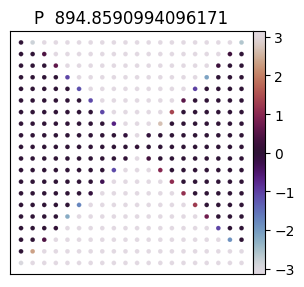

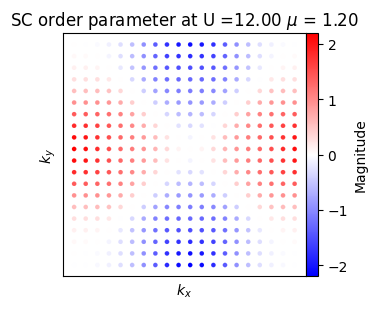

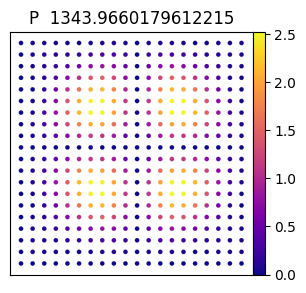

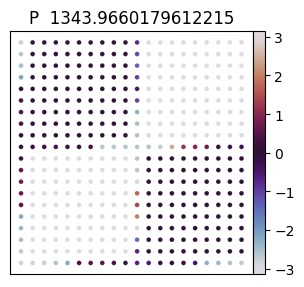

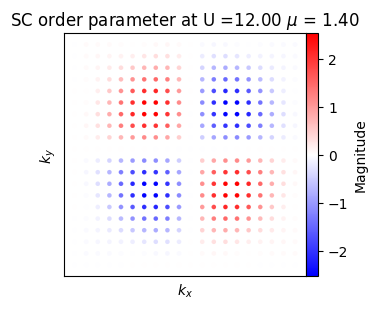

In [9]:
nk = 20 
nkf = 5
Us = "12.00"
model = "1NN t' = 0.00"
mu = [ "-1.40", "-1.20", "-1.00", "-0.80", "0.80", "1.00", "1.20", "1.40" ]
    
for mus in mu: 

    ff = "4.00"
    #La3Ni2O7_p100_8_4_4.00_2.00_1.00_out
    mod = do.read(f"1NN_{nk}_{nkf}_{Us}_{mus}_mod.dvg")
    mod.klabels=["G","M","X","G"]

    out = do.read(f"1NN_{nk}_{nkf}_{Us}_{mus}_out.dvg")

    plot_SCgap(out,mod,"P",out.Pvec[0],out.Pval[0], Us, mus, model,  real_space=False,)

/tmp/ipykernel_3430/3296732240.py:51: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  Ukooo[o1,o2,aa] += val


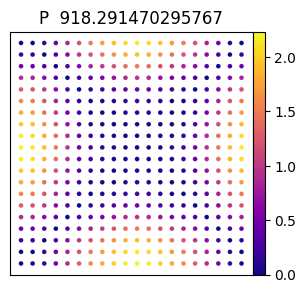

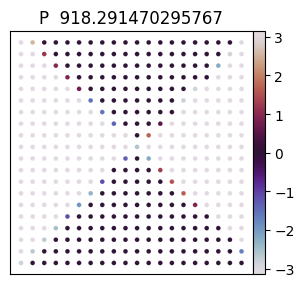

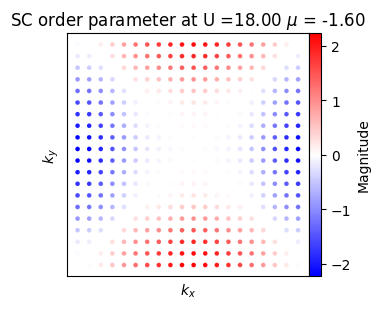

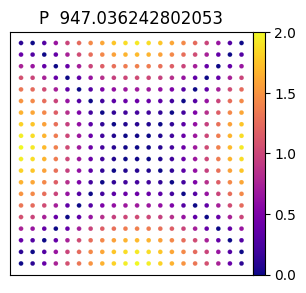

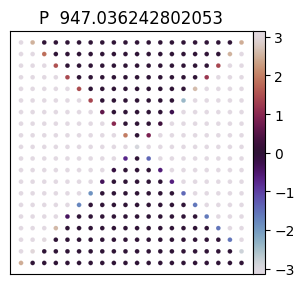

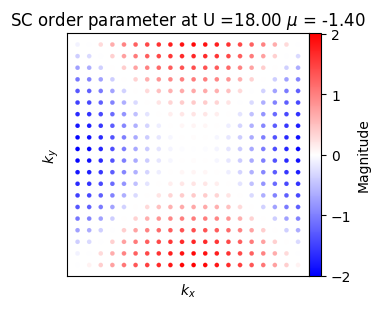

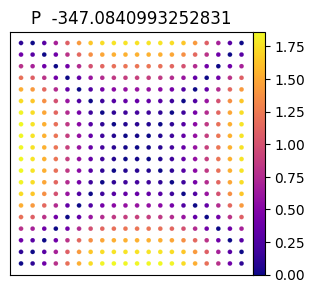

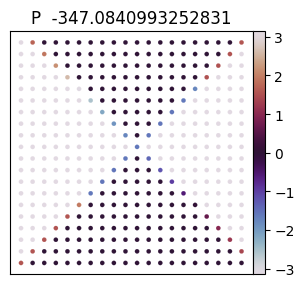

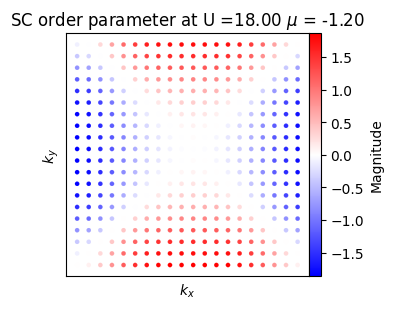

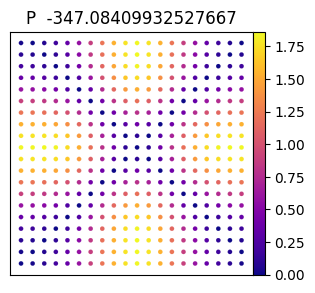

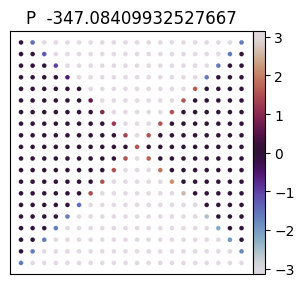

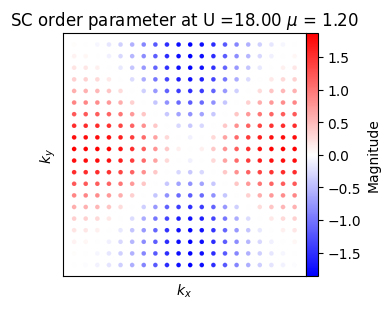

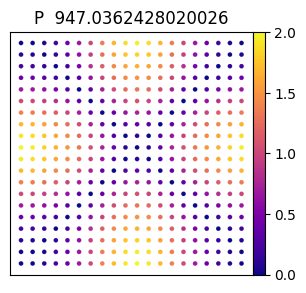

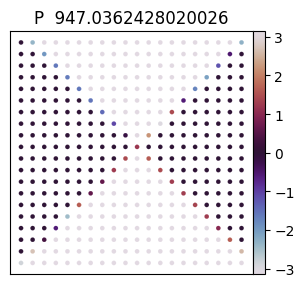

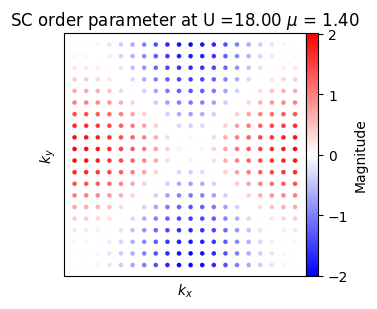

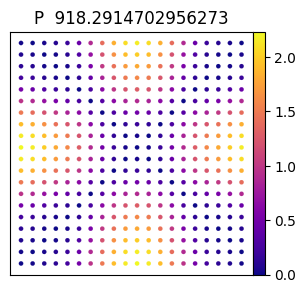

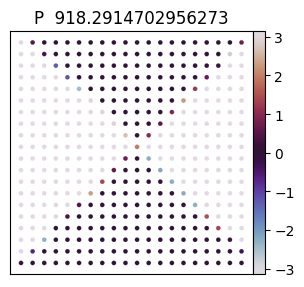

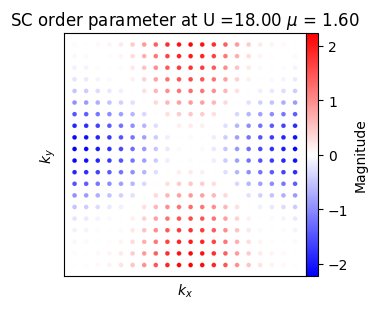

In [12]:
nk = 20 
nkf = 5
Us = "18.00"
model = "1NN t' = 0.00"
mu = [ "-1.60", "-1.40", "-1.20", "1.20", "1.40", "1.60" ]
    
for mus in mu: 

    ff = "4.00"
    #La3Ni2O7_p100_8_4_4.00_2.00_1.00_out
    mod = do.read(f"1NN_{nk}_{nkf}_{Us}_{mus}_mod.dvg")
    mod.klabels=["G","M","X","G"]

    out = do.read(f"1NN_{nk}_{nkf}_{Us}_{mus}_out.dvg")

    plot_SCgap(out,mod,"P",out.Pvec[0],out.Pval[0], Us, mus, model,  real_space=False,)